In [23]:
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import umap
import networkx as nx
from node2vec import Node2Vec
from TDAembedding import TDAembedding
from sbm_utils import generate_clusters
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat

%matplotlib inline

# Generate data

In [2]:
from sbm_utils import wsbm_built_in_block, wsbm_crossed_blocks, generate_wsbm_adj, generate_clusters

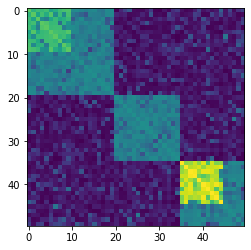

In [42]:
n=50
pi_vector=[0.4,0.3,0.3]
theta_in=2
theta_out=-2
n_blocks=[1,3]
enh_params=[1.5,2]
wAdj=generate_wsbm_adj(n,pi_vector,theta_in,theta_out)
wAdj_emb=wsbm_built_in_block(n,pi_vector,wAdj,n_blocks,enh_params)
wAdj_emb = wAdj_emb/np.max(wAdj_emb)
plt.imshow(wAdj_emb)
savemat("wsbm_embedded.mat",mdict={"wsbm_emb":wAdj_emb})

In [38]:
np.max(wAdj_emb)

1.0

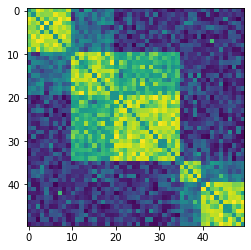

In [46]:
n=50
pi_vectors=[[0.4,0.3,0.3],[0.2,0.5,0.1,0.2]]
theta_ins=[1,3]
theta_outs=[-1,-3]
wAdj_mixed=wsbm_crossed_blocks(n,pi_vectors,theta_ins,theta_outs)
plt.imshow(wAdj_mixed)
wAdj_mixed = wAdj_mixed/np.max(wAdj_mixed)
savemat("wsbm_mixed.mat",mdict={"wsbm_mixed":wAdj_mixed})

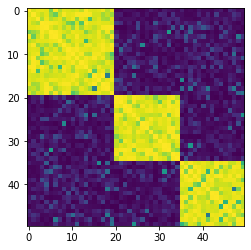

In [59]:
pi_vector=[0.4,0.3,0.3]
theta_in=3
theta_out=-3
wAdj = generate_wsbm_adj(n,[0.4,0.3,0.3],theta_in = theta_in,theta_out = theta_out)
plt.imshow(wAdj)
savemat(f"wsbm_base_{pi_vector[0]}_{pi_vector[1]}_{theta_in}_{abs(theta_out)}.mat",mdict={f"wsbm_base":wAdj})

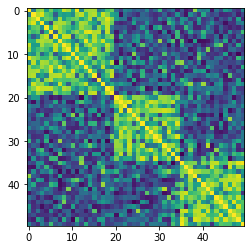

In [61]:
pi_vector=[0.4,0.3,0.3]
theta_in=1
theta_out=-1
wAdj = generate_wsbm_adj(n,[0.4,0.3,0.3],theta_in = theta_in,theta_out = theta_out)
plt.imshow(wAdj)
savemat(f"wsbm_base_{pi_vector[0]}_{pi_vector[1]}_{theta_in}_{abs(theta_out)}.mat",mdict={f"wsbm_base":wAdj})

# Comparing embedding node2vec and TDA with UMAP

In [64]:
def draw_node2vec(matrix, target,n_neighbors = 8):
    graph = nx.from_numpy_matrix(matrix)
    node2vec = Node2Vec(graph, dimensions=25, walk_length=15, p=0.5,q=1, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    nodes = [str(node) for node in range(wAdj.shape[0])]
    vecs = []
    for node in nodes:
        vecs.append(model.wv.__getitem__([node]))
    node2vec_ebds = np.squeeze(np.array(vecs))   
    reducer = umap.UMAP(n_neighbors=8, metric = 'cosine', n_components=2)
    u_emb = reducer.fit_transform(node2vec_ebds)
    #plt.scatter(u_emb[:, 0], u_emb[:, 1], c=[sns.color_palette()[x] for x in target])
    plt.scatter(u_emb[:, 0], u_emb[:, 1], c=target, cmap='Spectral', s=25)
    plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
    for i, txt in enumerate(nodes):
        plt.annotate(txt, (u_emb[i, 0], u_emb[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the node2vec embedding', fontsize=14);
    plt.show()

In [55]:
target = generate_clusters(50, pi_vector=[0.4,0.3,0.3]).astype('int')

## Strong blocks

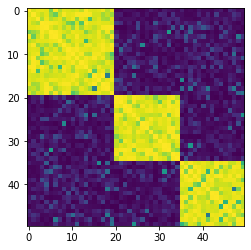

In [62]:
wAdj = loadmat("wsbm_base_0.4_0.3_3_3.mat")['wsbm_base']
plt.imshow(wAdj)

### Node2vec Embedding

Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 152.25it/s]


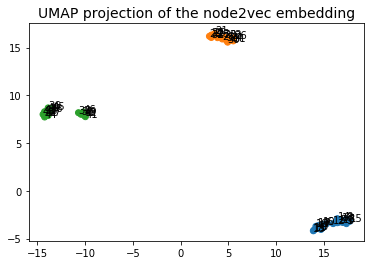

In [63]:
draw_node2vec(wAdj, target,n_neighbors = 8)

### TDA embedding

In [83]:
def find_TDA_embded(path_to_int, target, num_nodes = 50):
    embd = TDAembedding(path_to_int, num_nodes=num_nodes)
    intervals = embd.read_intervals(h0=True, h1=True)
    df0 = embd.create_h0_embedding(intervals=intervals)
    df1 = embd.create_h1_embedding(intervals=intervals)
    return df0,df1
def draw_TDA_umap(target, df0 = None, df1 = None, n_neighbors = 7):
    
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = 'cosine', n_components=2)
    u_emb0 = reducer.fit_transform(df0.values)
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = 'cosine', n_components=2)
    u_emb1 = reducer.fit_transform(df1.values)

    nodes = [str(node) for node in range(len(target))]
    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1);
    plt.scatter(u_emb0[:, 0], u_emb0[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
    for i, txt in enumerate(nodes):
        plt.annotate(txt, (u_emb0[i, 0], u_emb0[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the h0 embedding', fontsize=14);
    plt.subplot(1,2,2);
    plt.scatter(u_emb1[:, 0], u_emb1[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))
    for i, txt in enumerate(nodes):
        plt.annotate(txt, (u_emb1[i, 0], u_emb1[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the h1 embedding', fontsize=14);
    plt.show()

In [66]:
path_to_int = "ints_50_strong.txt"
df0, df1 = find_TDA_embded(path_to_int, target)

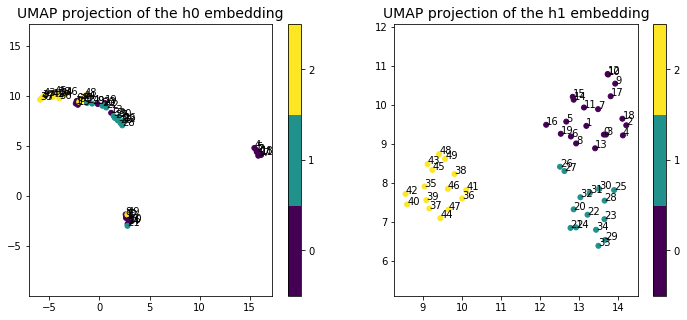

In [91]:
draw_TDA_umap(target, df0, df1, n_neighbors = 7)

## Mixed Model

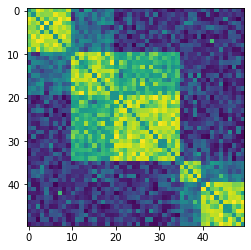

In [87]:
plt.imshow(wAdj_mixed)

Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 155.34it/s]


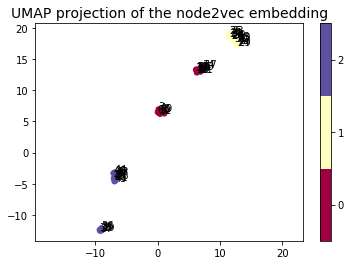

In [90]:
draw_node2vec(wAdj_mixed, target,n_neighbors = 10)

In [92]:
path_to_int = "ints_50_mixed.txt"
df0, df1 = find_TDA_embded(path_to_int, target)

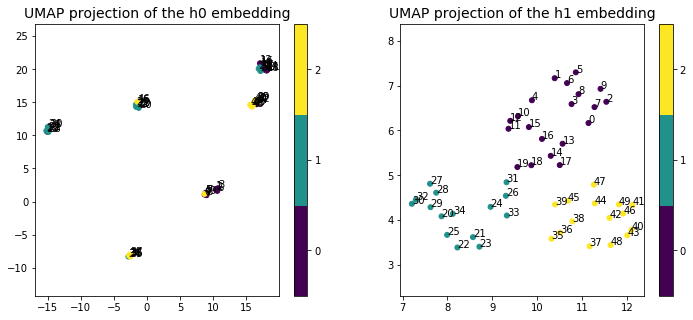

In [93]:
draw_TDA_umap(target, df0, df1, n_neighbors = 7)

## Embed Model

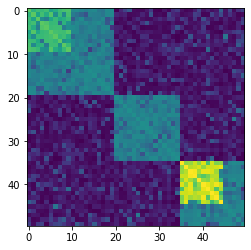

In [94]:
plt.imshow(wAdj_emb)

Computing transition probabilities: 100%|██████████| 50/50 [00:00<00:00, 150.35it/s]


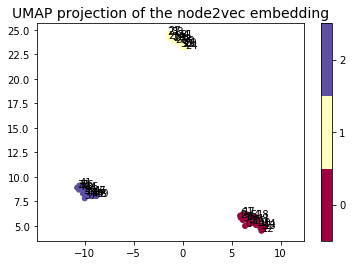

In [95]:
draw_node2vec(wAdj_emb, target,n_neighbors = 8)

In [96]:
path_to_int = "ints_50embed.txt"
df0, df1 = find_TDA_embded(path_to_int, target)

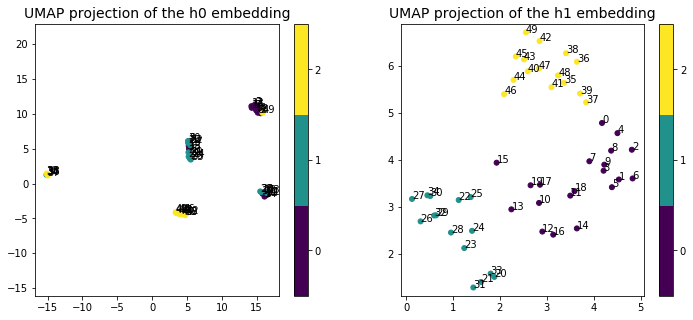

In [97]:
draw_TDA_umap(target, df0, df1, n_neighbors = 7)

## much better??